# Group 64: A Deep Look Into Mental Health Stigma in the Tech Workplace
<hr>

## 1. Imports

In [1]:
# Data wrangling and analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

# Data modeling
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## 2. Load the Data

In [2]:
mental14_df = pd.read_csv('data/mental_health_2014.csv')
mental16_df = pd.read_csv('data/mental_health_2016.csv')
mental16_meta_df = pd.read_json('data/mental_health_2016_meta_users.json')
geo_divs = pd.read_csv('data/geo_divs.csv')

## 3. Describe the Data

### 2014/2015 Dataset Features
1. <b>date_submit</b>
2. <b>age</b>
3. <b>gender</b>
4. <b>country_live</b>
5. <b>state_live</b>: If you live in the United States, which state or territory do you live in?
6. <b>self_employed</b>: Are you self-employed?
7. <b>family_history</b>: Do you have a family history of mental illness?
8. <b>treatment</b>: Have you sought treatment for a mental health condition?
9. <b>work_interfere</b>: If you have a mental health condition, do you feel that it interferes with your work?
10. <b>num_employees</b>: How many employees does your company or organization have?
11. <b>remote</b>: Do you work remotely (outside of an office) at least 50% of the time?
12. <b>tech_company</b>: Is your employer primarily a tech company/organization?
13. <b>benefits</b>: Does your employer provide mental health benefits?
14. <b>care_options</b>: Do you know the options for mental health care your employer provides?
16. <b>wellness_program</b>: Has your employer ever discussed mental health as part of an employee wellness program?
16. <b>emp_help</b>: Does your employer provide resources to learn more about mental health issues and how to seek help?
17. <b>anon</b>: Is your anonymity protected if you choose to take advantage of mental health or substance abuse         treatment resources?
18. <b>med_leave</b>: How easy is it for you to take medical leave for a mental health condition?
19. <b>ment_conseq</b>: Do you think that discussing a mental health issue with your employer would have         negative consequences?
20. <b>phys_conseq</b>: Do you think that discussing a physical health issue with your employer would have         negative consequences?
21. <b>coworkers</b>: Would you be willing to discuss a mental health issue with your coworkers?
22. <b>supervisors</b>: Would you be willing to discuss a mental health issue with your direct supervisor(s)?
23. <b>ment_interv</b>: Would you bring up a mental health issue with a potential employer in an interview?
24. <b>phys_interv</b>: Would you bring up a physical health issue with a potential employer in an interview?
25. <b>ment_vs_phys</b>: Do you feel that your employer takes mental health as seriously as physical health?
26. <b>obs_conseq</b>: Have you heard of or observed negative consequences for coworkers with mental health               conditions in your workplace?
27. <b>comments</b>: Any additional notes or comments

### Try to Group the Features
##### About the person
datetime, country, state, age, gender, self_employed, no_employees, remote_work, tech_company, treatment
##### Workplace programs and benefits
benefits, care_options, wellness_program, seek_help, anonymity, leave
##### Stigma and comfort level
work_interfere, mental_health_consequence, phys_health_consequence, coworkers, supervisor, mental_health_interview, phys_health_interview, mental_vs_physical, obs_consequence, comments

### Observations
 - 2016 has more features than 2014
 - Empty values: state, self_employed, work_interfere, comments
 - Timestamp: 2014-08-27 to 2016-02-01
 - Age: 8 values that are impossible/highly unlikely
 - Gender: very messy with misspellings and nonstandard values
 - state: 4 rows where state given but country is not USA, 11 rows where country is USA but no state given
 - self_employed: 18 NaN values
 - work_interfere: 264 NaN values; people might've answered it based on 'treatment'
 - comments: 1095 NaN values
 - people picked "Don't know" a lot
 - many of the later questions are contingent upon earlier ones

### Actions
 - Timestamp: split into features "date" and "time"
 - Age: replace the 8 values with randomly generated values between mean +/- std
 - Gender: replace misspelled values with "m" and "f"; pool nonstandard values into "o" (other)
 - state: consider USA states on the level of countries? fill 11 USA unnamed states with median or mode
 - self_employed: drop all rows with Yes, assume NaN = No
 - work_interfere: fill NaN with 'Not Applicable' (based on the way it's phrased, people might've answered it based on the previous question (treatment); OR create own ordinal category; OR just drop it since 2016 phrases it differently
 - comment: drop column

### 2016 Dataset Features
1. <b>date_land</b> : datetime of when survey is first opened
2. <b>date_submit</b> : datetime of when survey is submitted
3. <b>user_agent</b> : user's browser and computer
4. <b>self_employed</b> : Are you self-employed?
5. <b>num_employees</b> : How many employees does your company or organization have?
6. <b>tech_comp</b> : Is your employer primarily a tech company/organization?
7. <b>tech_role</b> : Is your primary role within your company related to tech/IT?
8. <b>benefits</b> : Does your employer provide mental health benefits as part of healthcare coverage?
9. <b>care_options</b> : Do you know the options for mental health care available under your employer-provided coverage?
10. <b>wellness_program</b> : Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
11. <b>emp_help</b> : Does your employer offer resources to learn more about mental health concerns and options for seeking help?
12. <b>anon</b> : Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
13. <b>med_leave</b> : If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:
14. <b>ment_conseq</b> : Do you think that discussing a mental health disorder with your employer would have negative consequences?
15. <b>phys_conseq</b> : Do you think that discussing a physical health issue with your employer would have negative consequences?
16. <b>coworkers</b> : Would you feel comfortable discussing a mental health disorder with your coworkers?
17. <b>supervisors</b> : Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?
18. <b>ment_vs_phys</b> : Do you feel that your employer takes mental health as seriously as physical health?
19. <b>obs_conseq</b> : Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?
20. <b>ment_med_cov</b> : Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?
21. <b>online_help</b> : Do you know local or online resources to seek help for a mental health disorder?
22. <b>reveal_clients</b> : If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?
23. <b>reveal_clients_neg</b> : If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?
24. <b>reveal_workers</b> : If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?
25. <b>reveal_workers_neg</b> : If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?
26. <b>productivity</b> : Do you believe your productivity is ever affected by a mental health issue?
27. <b>productivity_perc</b> : If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?
28. <b>prev_emps</b> : Do you have previous employers?
29. <b>pe_benefits</b> : Have your previous employers provided mental health benefits?
30. <b>pe_care_options</b> : Were you aware of the options for mental health care provided by your previous employers?
31. <b>pe_wellness_program</b> : Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?
32. <b>pe_emp_help</b> : Did your previous employers provide resources to learn more about mental health issues and how to seek help?
33. <b>pe_anon</b> : Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?
34. <b>pe_ment_conseq</b> : Do you think that discussing a mental health disorder with previous employers would have negative consequences?
35. <b>pe_phys_conseq</b> : Do you think that discussing a physical health issue with previous employers would have negative consequences?
36. <b>pe_coworkers</b> : Would you have been willing to discuss a mental health issue with your previous co-workers?
37. <b>pe_supervisors</b> : Would you feel comfortable discussing a mental health disorder with your previous direct supervisor(s)?
38. <b>pe_ment_vs_phys</b> : Did you feel that your previous employers took mental health as seriously as physical health?
39. <b>pe_obs_conseq</b> : Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?
40. <b>phys_interv</b> : Would you be willing to bring up a physical health issue with a potential employer in an interview?
41. <b>phys_interv_why</b> : Reason for choosing the above
42. <b>ment_interv</b> : Would you bring up a mental health issue with a potential employer in an interview?
43. <b>ment_interv_why</b> : Reason for choosing the above
44. <b>ment_hurt_career</b> : Do you feel that being identified as a person with a mental health issue would hurt your career?
45. <b>coworkers_neg</b> : Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?
46. <b>share_fam</b> : How willing would you be to share with friends and family that you have a mental illness?
47. <b>bad_event</b> : Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?
48. <b>less_another</b> : Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?
49. <b>family_history</b> : Do you have a family history of mental illness?
50. <b>past_disorder</b> : Have you had a mental health disorder in the past?
51. <b>current_disorder</b> : Do you currently have a mental health disorder?
52. <b>yes_condition</b> : If yes, what condition(s) have you been diagnosed with?
53. <b>maybe_condition</b> : If maybe, what condition(s) do you believe you have?
54. <b>diagnosis</b> : Have you been diagnosed with a mental health condition by a medical professional?
55. <b>diag_condition</b> : If so, what condition(s) were you diagnosed with?
56. <b>treatment</b> : Have you ever sought treatment for a mental health issue from a mental health professional?
57. <b>interfere_treated</b> : If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?
58. <b>interfere_untreated</b> : If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?
59. <b>age</b> : What is your age?
60. <b>gender</b> : What is your gender?
61. <b>country_live</b> : What country do you live in?
62. <b>state_live</b> : What US state or territory do you live in?
63. <b>country_work</b> : What country do you work in?
64. <b>state_work</b> : What US state or territory do you work in?
65. <b>job_position</b> : Which of the following best describes your work position?
66. <b>remote</b> : Do you work remotely?

### Extra Features Not in 2014 Dataset
1. tech_role
2. ment_med_cov
3. online_help
4. reveal_clients
5. reveal_clients_neg
6. reveal_workers
7. reveal_workers_neg
8. productivity
9. productivity_perc
10. prev_emps
11. pe_benefits
12. pe_care_options
13. pe_wellness_program
14. pe_emp_help
15. pe_anon
16. pe_ment_conseq
17. pe_phys_conseq
18. pe_coworkers
19. pe_supervisors
20. pe_ment_vs_phys
21. pe_obs_conseq
22. phys_interv_why
23. ment_interv_why
24. ment_hurt_career
25. coworkers_neg
26. share_fam
27. bad_event
28. less_another
29. past_disorder
30. current_disorder
31. yes_condition
32. maybe_condition
33. diagnosis
34. diag_condition
35. interfere_treated
36. interfere_untreated
37. country_work
38. state_work
39. job_position
40. date_land
41. user_agent
42. comments

### Observations
 - 2014 and 2016 has 25 features in common; 42 not in common
 - work_interfere is split into 2 questions in the 2016 dataset for untreated vs treated
 - 2016-03-14 to 2016-11-12
 - 1433 observations even though shorter timespan than the 2014 survey
 - age: same deal as 2014
 - gender: same deal as 2014
 - country and states looks to be clean
 - num_employees: 287 NaN values
 - benefits: 287 NaN values
 - care_options: 420 NaN
 - wellness_program: 287 NaN
 - emp_help: 287 NaN
 - anon: 287 NaN
 - med_leave: 287 NaN
 - ment_conseq: 287 NaN
 - phys_conseq: 287 NaN
 - coworkers: 287 NaN
 - supervisors: 287 NaN
 - ment_vs_phys: 287 NaN
 - Who are the 287 NaN people?
   - These are actually the self_employed people: most actually have the past_employer section filled out

### Actions
 - relabel 2016 to match 2014 for columns in common (DONE)
 - EITHER drop work_interfere from combined_df altogether; OR take the average of treated & untreated for each row (DONE)
 - Figure out what's the deal with the 287 NaN before combining
 - Timestamp: split into features "date" and "time"
 - Age: replace the outlier values with randomly generated values between mean +/- std
 - Gender: replace misspelled values with "m" and "f"; pool nonstandard values into "o" (other)
 - state: consider USA states on the level of countries since heavily skewed USA?
 - self_employed: fill NaN according to overall proportion of Yes:No
     - Lets drop it. Most of the questions wouldn't be very relevant for those people

## 4. Clean the Data

In [3]:
mental14_df.shape

(1259, 27)

In [4]:
mental14_relabels = [
    'date_submit', 'age', 'gender', 'country_live', 'state_live', 'self_employed', 'family_history', 'treatment',
    'work_interfere', 'num_employees', 'remote', 'tech_comp', 'benefits', 'care_options', 'wellness_program', 
    'emp_help', 'anon', 'med_leave', 'ment_conseq', 'phys_conseq', 'coworkers', 'supervisors', 'ment_interv',
    'phys_interv', 'ment_vs_phys', 'obs_conseq', 'comments' 
]

In [5]:
mental14_df.columns = mental14_relabels

In [6]:
mental14_df.head()

,date_submit,age,gender,country_live,state_live,self_employed,family_history,treatment,work_interfere,num_employees,remote,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_interv,phys_interv,ment_vs_phys,obs_conseq,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [7]:
mental14_df.describe()

,age
count,1.259000e+03
mean,7.942815e+07
std,2.818299e+09
min,-1.726000e+03
25%,2.700000e+01
50%,3.100000e+01
75%,3.600000e+01
max,1.000000e+11


In [8]:
mental14_df.describe(include=['O'])

,date_submit,gender,country_live,state_live,self_employed,family_history,treatment,work_interfere,num_employees,remote,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_interv,phys_interv,ment_vs_phys,obs_conseq,comments
count,1259,1259,1259,744,1241,1259,1259,995,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,164
unique,1246,49,48,45,2,2,2,4,6,2,2,3,3,3,3,3,5,3,3,3,3,3,3,3,2,160
top,2014-08-27 15:24:47,Male,United States,CA,No,No,Yes,Sometimes,6-25,No,Yes,Yes,No,No,No,Don't know,Don't know,No,No,Some of them,Yes,No,Maybe,Don't know,No,* Small family business - YMMV.
freq,2,615,751,138,1095,767,637,465,290,883,1031,477,501,842,646,819,563,490,925,774,516,1008,557,576,1075,5


### Extract and Merge Timestamps Into 2016 DF

In [9]:
mental16_df.shape, mental16_meta_df.shape

((1433, 63), (1433, 5))

In [10]:
mental16_meta_df = pd.DataFrame.from_records(mental16_meta_df.metadata.values)

In [11]:
mental16_meta_df.drop(['browser', 'network_id', 'platform', 'referer'], axis=1, inplace=True)

In [12]:
mental16_df = pd.concat([mental16_meta_df, mental16_df], axis=1)

In [13]:
mental16_relabels = [
    'date_land', 'date_submit', 'user_agent', 'self_employed', 'num_employees', 'tech_comp', 'tech_role',
    'benefits', 'care_options', 'wellness_program', 'emp_help', 'anon', 'med_leave', 'ment_conseq',
    'phys_conseq', 'coworkers', 'supervisors', 'ment_vs_phys', 'obs_conseq', 'ment_med_cov', 'online_help',
    'reveal_clients', 'reveal_clients_neg', 'reveal_workers', 'reveal_workers_neg', 'productivity',
    'productivity_perc', 'prev_emps', 'pe_benefits', 'pe_care_options', 'pe_wellness_program', 'pe_emp_help',
    'pe_anon', 'pe_ment_conseq', 'pe_phys_conseq', 'pe_coworkers', 'pe_supervisors', 'pe_ment_vs_phys',
    'pe_obs_conseq', 'phys_interv', 'phys_interv_why', 'ment_interv', 'ment_interv_why', 'ment_hurt_career',
    'coworkers_neg', 'share_fam', 'bad_event', 'less_another', 'family_history', 'past_disorder',
    'current_disorder', 'yes_condition', 'maybe_condition', 'diagnosis', 'diag_condition', 'treatment',
    'interfere_treated', 'interfere_untreated', 'age', 'gender', 'country_live', 'state_live', 'country_work',
    'state_work', 'job_position', 'remote'
]

In [14]:
mental16_df.columns = mental16_relabels

### Create work_interfere Feature for 2016

In [15]:
work_interfere_to_num = {'Not applicable to me': 0, 'Never': 1, 'Rarely': 2, 'Sometimes': 3, 'Often': 4}
num_to_work_interfere = {0: 'Not applicable to me', 1: 'Never', 2: 'Rarely', 3: 'Sometimes', 4: 'Often'}
work_interfere = []

for ind, row in mental16_df[['interfere_untreated', 'interfere_treated']].iterrows():
    # if 'Not applicable' for either column then add the other one that has a value
    row_mapped = row.map(work_interfere_to_num)
    if row_mapped[0] == 0 or row_mapped[1] == 0:
        work_interfere.append(row_mapped.max())
    # else take the average between both columns and randomly round up or down
    else:
        temp_val = row_mapped.mean()
        round_up_down = np.random.randint(0, 2)
        if not temp_val.is_integer():
            if round_up_down == 0:
                temp_val = np.floor(temp_val)
            if round_up_down == 1:
                temp_val = np.ceil(temp_val)
        work_interfere.append(int(temp_val))
work_interfere = pd.Series(work_interfere).map(num_to_work_interfere)

In [16]:
mental16_df['work_interfere'] = work_interfere

In [17]:
mental16_df.shape

(1433, 67)

### Combine 2014 and 2016 Dataframes

In [18]:
combined_df = pd.concat([mental14_df,mental16_df],join='inner')

In [19]:
combined_df.reset_index(drop=True, inplace=True)

In [20]:
combined_df.tail()

,date_submit,self_employed,num_employees,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,phys_interv,ment_interv,family_history,treatment,age,gender,country_live,state_live,remote,work_interfere
2687,2016-11-07 19:58:03,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,Yes,1,34,Female,United States of America,New York,Sometimes,Not applicable to me
2688,2016-11-10 03:53:18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Maybe,No,Yes,0,56,MALE,United States of America,California,Sometimes,Sometimes
2689,2016-11-10 16:49:32,0,100-500,1,Yes,Yes,Yes,Yes,I don't know,Somewhat difficult,Maybe,Maybe,Yes,Yes,I don't know,Yes,Maybe,No,Yes,1,52,Male,United States of America,Georgia,Sometimes,Sometimes
2690,2016-11-11 15:21:13,0,100-500,0,I don't know,I am not sure,No,Yes,I don't know,Somewhat difficult,Maybe,No,Maybe,Yes,No,No,Maybe,No,Yes,0,30,Female,United States of America,Nebraska,Sometimes,Sometimes
2691,2016-11-12 06:05:16,0,100-500,1,Yes,No,No,No,I don't know,Very difficult,Maybe,No,Maybe,Maybe,No,No,Maybe,No,I don't know,0,25,non-binary,Canada,NaN,Sometimes,Often


In [21]:
combined_df.shape

(2692, 26)

### Drop Troublesome Rows/Columns

In [22]:
# Drop rows where self_employed == yes ; then drop the column
combined_df.drop(combined_df[(
    combined_df.self_employed == 1) | (
    combined_df.self_employed == 'Yes'
)].index, axis=0, inplace=True)

combined_df.drop('self_employed', axis=1, inplace=True)

In [23]:
# Drop country_live = Other
combined_df.drop(combined_df[combined_df.country_live == 'Other'].index, axis=0, inplace=True)

In [24]:
combined_df.reset_index(drop=True, inplace=True)

In [25]:
combined_df.shape

(2258, 25)

### Tell Coworkers

In [26]:
combined_df.loc[(combined_df.coworkers == 'No'), 'coworkers'] = -1
combined_df.loc[(combined_df.coworkers == 'Maybe') | (combined_df.coworkers == 'Some of them'), 'coworkers'] = 0
combined_df.loc[(combined_df.coworkers == 'Yes'), 'coworkers'] = 1

### Tell Supervisors

In [27]:
combined_df.loc[(combined_df.supervisors == 'No'), 'supervisors'] = -1
combined_df.loc[(combined_df.supervisors == 'Maybe') | (
    combined_df.supervisors == 'Some of them'), 'supervisors'] = 0
combined_df.loc[(combined_df.supervisors == 'Yes'), 'supervisors'] = 1

### Discuss Mental Health in Interview

In [28]:
combined_df.loc[(combined_df.ment_interv == 'No'), 'ment_interv'] = -1
combined_df.loc[(combined_df.ment_interv == 'Maybe'), 'ment_interv'] = 0
combined_df.loc[(combined_df.ment_interv == 'Yes'), 'ment_interv'] = 1

### Consequence of Discussing Mental Health

In [29]:
combined_df.loc[(combined_df.ment_conseq == 'No'), 'ment_conseq'] = -1
combined_df.loc[(combined_df.ment_conseq == 'Maybe'), 'ment_conseq'] = 0
combined_df.loc[(combined_df.ment_conseq == 'Yes'), 'ment_conseq'] = 1

### *Stigma Rating

In [30]:
# Lumped rating to describe how open or comfortable a person is about discussing their
# mental health issues with others in the workplace
# 1 = willing to discuss
# -1 = unwilling to discuss
# 0 = a lot of Maybe's or uncertainty
combined_df['stigma'] = (combined_df.coworkers + \
                              combined_df.supervisors + \
                              combined_df.ment_interv - \
                              combined_df.ment_conseq)/4

In [31]:
combined_df.stigma.mean()

-0.12245349867139062

### Care Options

In [32]:
combined_df.loc[(combined_df.care_options == 'No'), 'care_options'] = -1
combined_df.loc[(combined_df.care_options == 'I am not sure') | (
    combined_df.care_options == 'Not sure') | (
    combined_df.care_options.isnull()), 'care_options'] = 0
combined_df.loc[(combined_df.care_options == 'Yes'), 'care_options'] = 1

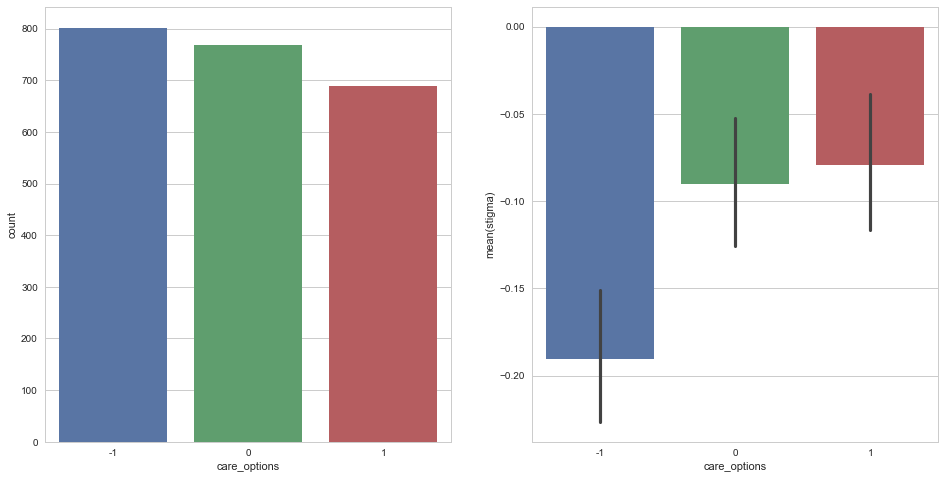

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sns.countplot(x='care_options', data=combined_df, ax=ax1)
sns.barplot(x='care_options', y='stigma', data=combined_df, ax=ax2)

### Wellness Program

In [34]:
combined_df.loc[(combined_df.wellness_program == 'No'), 'wellness_program'] = -1
combined_df.loc[(combined_df.wellness_program == 'I don\'t know') | (
    combined_df.wellness_program == 'Don\'t know'), 'wellness_program'] = 0
combined_df.loc[(combined_df.wellness_program == 'Yes'), 'wellness_program'] = 1

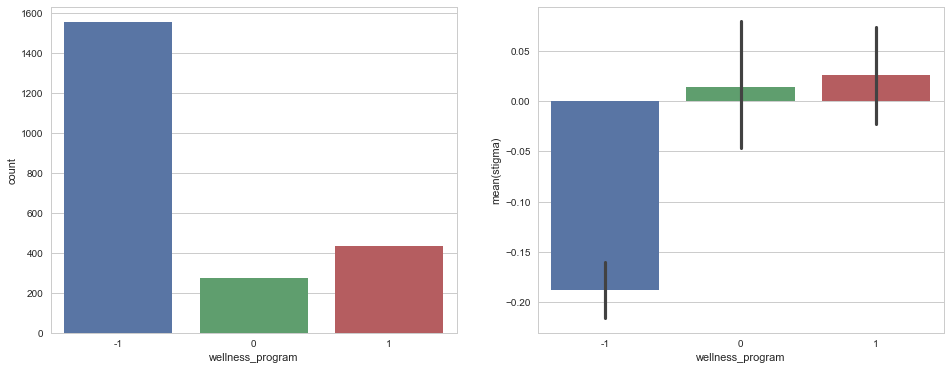

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(x='wellness_program', data=combined_df, ax=ax1)
sns.barplot(x='wellness_program', y='stigma', data=combined_df, ax=ax2)

### Employer Resources for Help

In [36]:
combined_df.loc[(combined_df.emp_help == 'No'), 'emp_help'] = -1
combined_df.loc[(combined_df.emp_help == 'I don\'t know') | (
    combined_df.emp_help == 'Don\'t know'), 'emp_help'] = 0
combined_df.loc[(combined_df.emp_help == 'Yes'), 'emp_help'] = 1

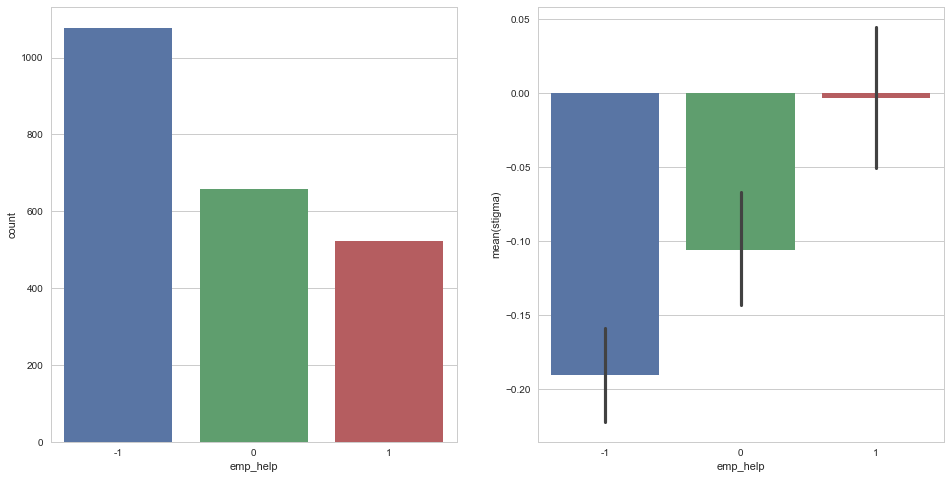

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sns.countplot(x='emp_help', data=combined_df, ax=ax1)
sns.barplot(x='emp_help', y='stigma', data=combined_df, ax=ax2)

### *Resource Promotion Rating

In [38]:
# Lumped rating to describe how active employers are in promoting mental health
# resources and awareness to employees
# 1 = frequent promotion
# -1 = sparse promotion
combined_df['resource_promo'] = (combined_df.care_options + combined_df.wellness_program + combined_df.emp_help)/3

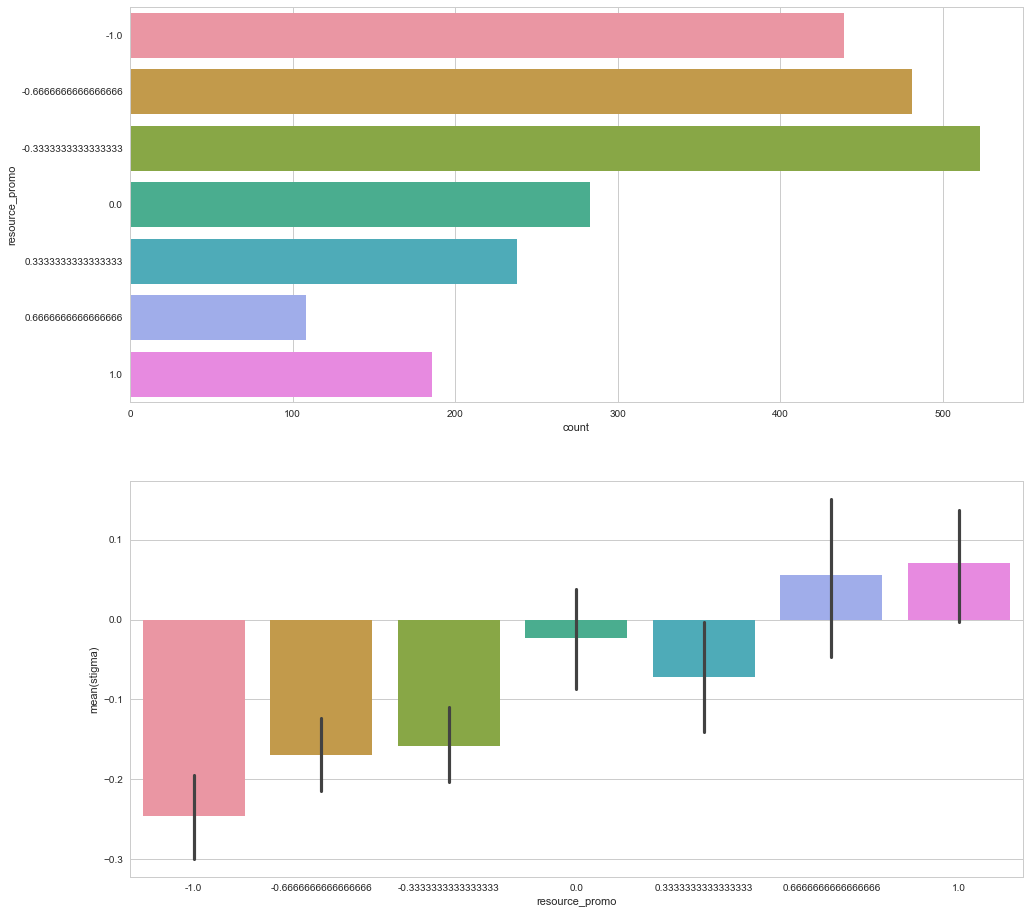

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16))
sns.countplot(y='resource_promo', data=combined_df, ax=ax1)
sns.barplot(y='stigma', x='resource_promo', data=combined_df, ax=ax2)

### Consequence of Discussing Physical Health

In [40]:
combined_df.loc[(combined_df.phys_conseq == 'No'), 'phys_conseq'] = -1
combined_df.loc[(combined_df.phys_conseq == 'Maybe'), 'phys_conseq'] = 0
combined_df.loc[(combined_df.phys_conseq == 'Yes'), 'phys_conseq'] = 1

### Discuss Physical Health in Interview

In [41]:
combined_df.loc[(combined_df.phys_interv == 'No'), 'phys_interv'] = -1
combined_df.loc[(combined_df.phys_interv == 'Maybe'), 'phys_interv'] = 0
combined_df.loc[(combined_df.phys_interv == 'Yes'), 'phys_interv'] = 1

### Mental vs Physical

In [42]:
combined_df.loc[(combined_df.ment_vs_phys == 'No'), 'ment_vs_phys'] = -1
combined_df.loc[(combined_df.ment_vs_phys == 'I don\'t know') | (
    combined_df.ment_vs_phys == 'Don\'t know'), 'ment_vs_phys'] = 0
combined_df.loc[(combined_df.ment_vs_phys == 'Yes'), 'ment_vs_phys'] = 1

### *Physical-Mental Rating

In [43]:
# Lumped rating to describe person's perception mental vs physical health stigma
# 1 = mental is worst off
# -1 = physical is worst off
combined_df['phys_ment'] = ((
    combined_df.ment_conseq - combined_df.ment_interv) - (
    combined_df.phys_conseq - combined_df.phys_interv) + (
    combined_df.ment_vs_phys))/5

### Date Submitted

In [44]:
# string to datetime
combined_df.date_submit = pd.to_datetime(combined_df.date_submit)

In [45]:
# New features to see if there are any time dependent patterns
combined_df['year'] = combined_df.date_submit.dt.year
combined_df['month'] = combined_df.date_submit.dt.month
combined_df['week_day'] = combined_df.date_submit.dt.dayofweek # where 0 = Monday
combined_df['hour'] = combined_df.date_submit.dt.hour

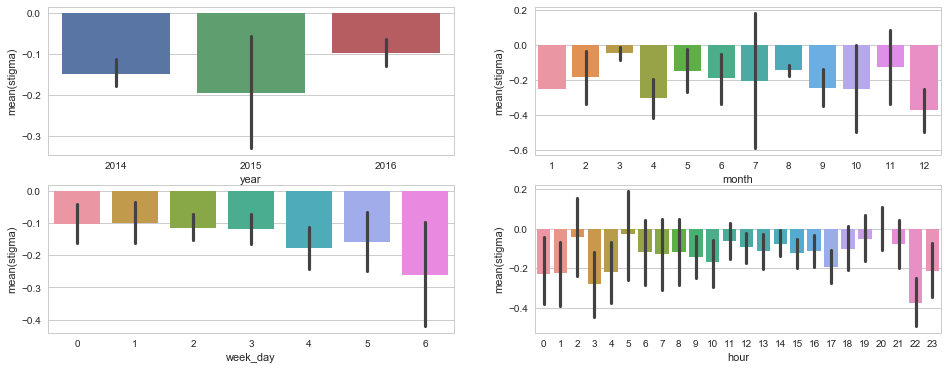

In [46]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(16, 6))
sns.barplot(y='stigma', x='year', data=combined_df, ax=ax1)
sns.barplot(y='stigma', x='month', data=combined_df, ax=ax2)
sns.barplot(y='stigma', x='week_day', data=combined_df, ax=ax3)
sns.barplot(y='stigma', x='hour', data=combined_df, ax=ax4)

### Age

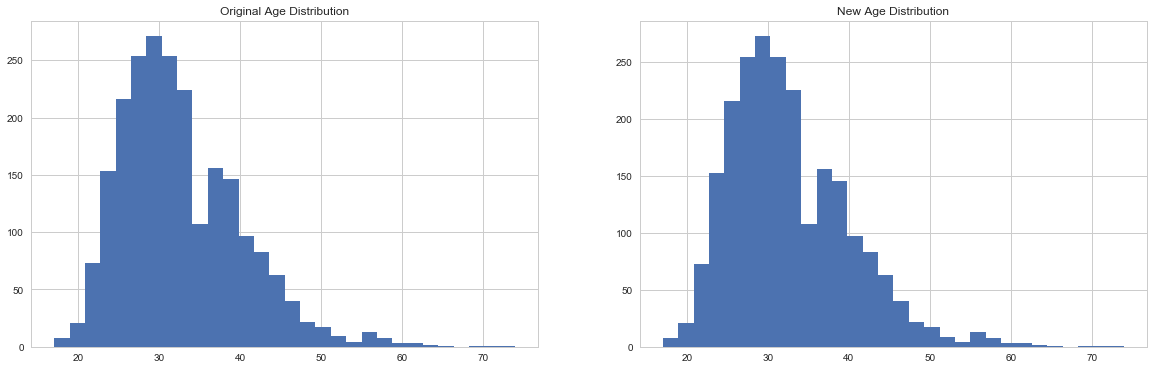

In [47]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(20, 6))
axis1.set_title('Original Age Distribution')
axis2.set_title('New Age Distribution')

# get median, Q1, Q3, and number of outlier ages
typical_ages = combined_df.loc[(combined_df.age >= 17) & (combined_df.age <= 90), 'age']
outlier_ages = combined_df.loc[(combined_df.age > 90) | (combined_df.age < 17), 'age']
median_age = typical_ages.median()
q1_age = typical_ages.quantile(0.25)
q3_age = typical_ages.quantile(0.75)
num_outlier_ages = len(outlier_ages)

# generate random ages between 1st and 3rd quantiles
new_ages = np.random.randint(q1_age, q3_age, size=num_outlier_ages)

# plot orig age distrib without the outliers
typical_ages.hist(bins=30, ax=axis1)

# fill outlier ages with new values
combined_df.loc[(combined_df.age > 90) | (combined_df.age < 17), 'age'] = new_ages
combined_df.age = combined_df.age.astype(int)

# plot age distribution with new values
combined_df.age.hist(bins=30, ax=axis2)

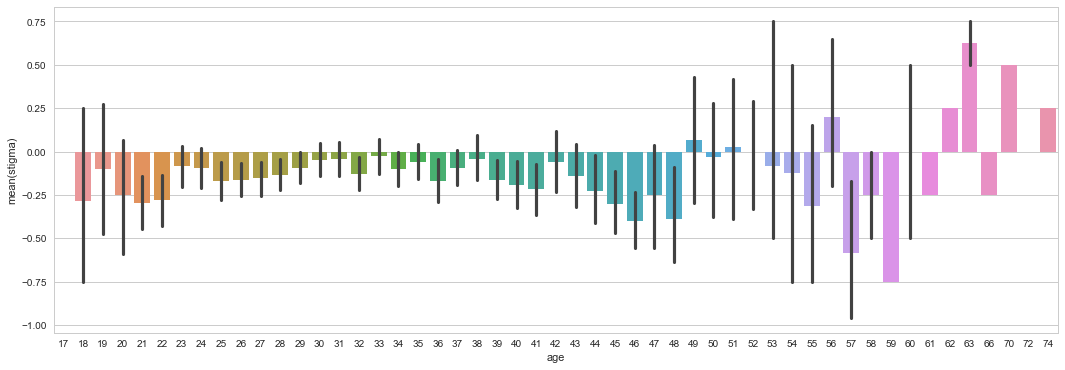

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(18,6))
sns.barplot(x='age', y='stigma', data=combined_df)

In [49]:
# Add cut age into age bands
# combined_df['age_split'] = pd.cut(combined_df.age, 5, precision=0)
# combined_df.age_split.value_counts(dropna=False)
# combined_df.loc[combined_df.age <= 28, 'age_band'] = 0
# combined_df.loc[(combined_df.age > 28) & (combined_df.age <= 40), 'age_band'] = 1
# combined_df.loc[(combined_df.age > 40) & (combined_df.age <= 51), 'age_band'] = 2
# combined_df.loc[(combined_df.age > 51) & (combined_df.age <= 63), 'age_band'] = 3
# combined_df.loc[combined_df.age > 63, 'age_band'] = 4
# combined_df.age_band = combined_df.age_band.astype(int)

### Gender

In [50]:
# Separate all the unique responses into male, female, and other
all_gender = list(combined_df.gender.unique())
condit_female = ['Female', 'female', 'F', 'f', 'Femake', 'woman', 'Female ', 'Woman', 'femail',
                'I identify as female.', 'fm', 'female/woman', 'female ', 'fem',
                'Female (props for making this a freeform field, though)', ' Female']
condit_male = ['M', 'Male', 'male', 'maile', 'm', 'Make', 'Male ', 'Man', 'msle', 'Mail', 'Malr', 'man', 'Male.',
              'Sex is male', 'Dude', 'mail', 'male ']
condit_other = [i for i in all_gender if (i not in condit_male) and (i not in condit_female)] 

In [51]:
# Relabel according to each category
combined_df.loc[(combined_df.gender.isin(condit_male)), 'gender'] = -1
combined_df.loc[(combined_df.gender.isin(condit_other)), 'gender'] = 0
combined_df.loc[(combined_df.gender.isin(condit_female)), 'gender'] = 1

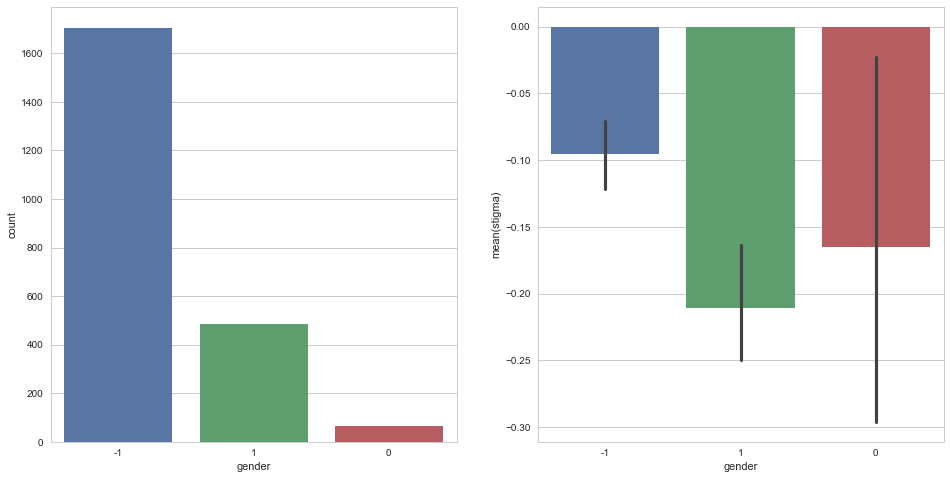

In [52]:
# plot counts for each gender
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
sns.countplot(x='gender', data=combined_df, ax=ax1, order=combined_df.gender.value_counts().index)
sns.barplot(x='gender', y='stigma', data=combined_df, ax=ax2, order=combined_df.gender.value_counts().index)

### Location

In [53]:
# Put together the USA & US responses
combined_df.loc[(combined_df.country_live == 'United States of America'), 'country_live'] = 'United States'

In [54]:
# Set state_live = NaN for non USA countries
combined_df.loc[(
    combined_df.state_live.notnull()) & (
    combined_df.country_live != 'United States'), 'state_live'] = np.nan

In [55]:
# Set state_live = the mode (California) for USA responses with NaN state_live
combined_df.loc[(
    combined_df.state_live.isnull()) & (
    combined_df.country_live == 'United States'), 'state_live'] = 'California'

In [56]:
# Convert abbrev. state_live responses to full name
state_abbr_full = {'IL': 'Illinois', 'IN': 'Indiana', 'TX': 'Texas', 'TN': 'Tennessee', 'MI': 'Michigan',
                  'OH': 'Ohio', 'CA': 'California', 'CT': 'Connecticut', 'NY': 'New York', 'MA': 'Massachusetts',
                  'IA': 'Iowa', 'WA': 'Washington', 'WI': 'Wisconsin', 'UT': 'Utah', 'NM': 'New Mexico',
                  'OR': 'Oregon', 'FL': 'Florida', 'MN': 'Minnesota', 'MO': 'Missouri', 'AZ': 'Arizona',
                  'CO': 'Colorado', 'GA': 'Georgia', 'DC': 'District of Columbia', 'NE': 'Nebraska',
                  'MD': 'Maryland', 'PA': 'Pennsylvania', 'WV': 'West Virginia', 'OK': 'Oklahoma',
                  'NC': 'North Carolina', 'KS': 'Kansas', 'VA': 'Virginia', 'NH': 'New Hampshire', 'KY': 'Kentucky',
                  'AL': 'Alabama', 'NV': 'Nevada', 'NJ': 'New Jersey', 'SC': 'South Carolina', 'VT': 'Vermont',
                  'SD': 'South Dakota', 'ID': 'Idaho', 'RI': 'Rhode Island', 'WY': 'Wyoming', 'LA': 'Louisiana',
                  'ME': 'Maine', 'AK': 'Alaska', 'AR': 'Arkansas', 'DE': 'Delaware', 'HI': 'Hawaii',
                  'MS': 'Mississippi', 'MT': 'Montana', 'ND': 'North Dakota'}
combined_df.loc[(combined_df.state_live.str.len() == 2), 'state_live'] = combined_df.loc[(combined_df.state_live.str.len() == 2), 'state_live'].map(state_abbr_full)

In [57]:
# Create feature 'location' that splits USA by states and considers them on same level as other countries
combined_df['location'] = combined_df.country_live
combined_df.loc[(
    combined_df.state_live.notnull()) & (
    combined_df.country_live == 'United States'), 'location'] = combined_df.state_live

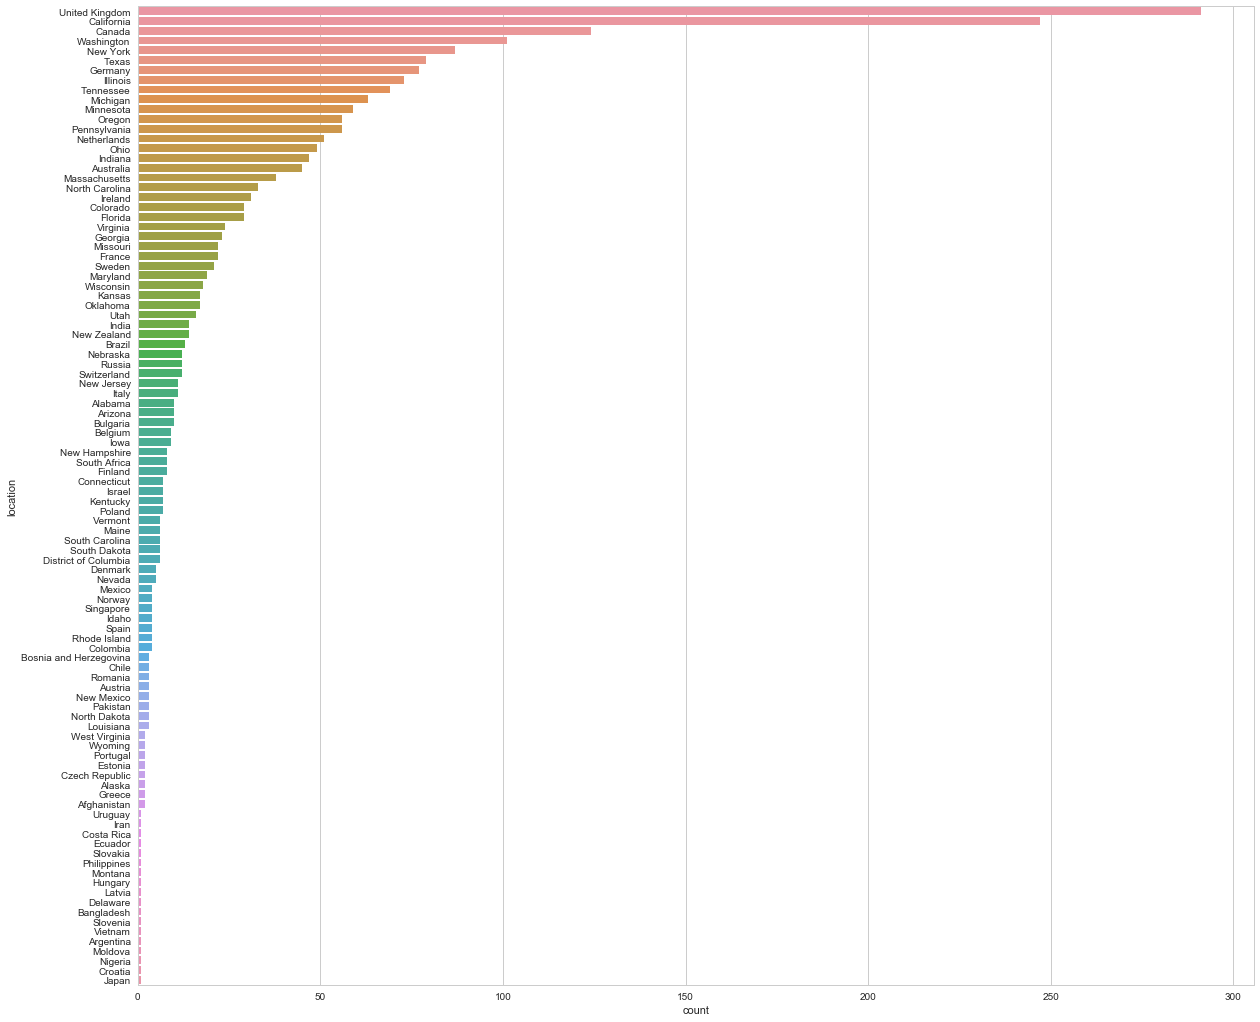

In [58]:
fig, axis = plt.subplots(1, 1, figsize=(20,18))
sns.countplot(y='location', data=combined_df, ax=axis, order=combined_df.location.value_counts().index)

### Family History of Mental Illness

In [59]:
# Relabel
combined_df.loc[(combined_df.family_history == 'No'), 'family_history'] = -1
combined_df.loc[(combined_df.family_history == 'I don\'t know'), 'family_history'] = 0
combined_df.loc[(combined_df.family_history == 'Yes'), 'family_history'] = 1

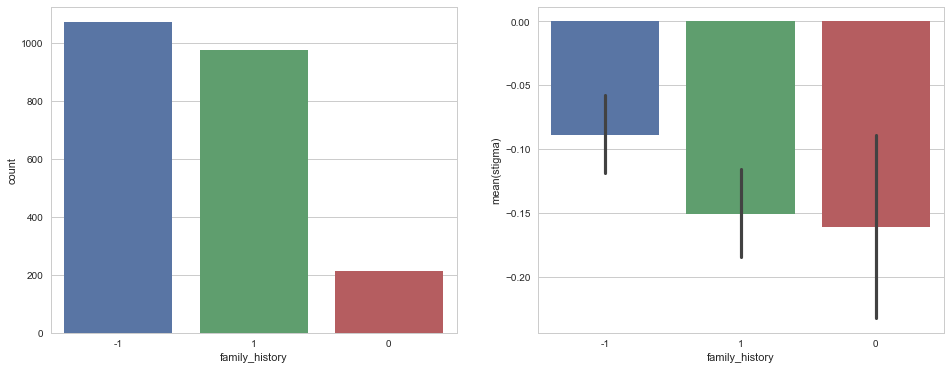

In [60]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(x='family_history', data=combined_df, ax=ax1, order=combined_df.family_history.value_counts().index)
sns.barplot(x='family_history', y='stigma', data=combined_df, ax=ax2, order=combined_df.family_history.value_counts().index)

### Sought Treatment

In [61]:
# Relabel yes = 1, no = 0
combined_df.loc[(combined_df.treatment == 'No') | (combined_df.treatment == 0), 'treatment'] = -1
combined_df.loc[(combined_df.treatment == 'Yes'), 'treatment'] = 1

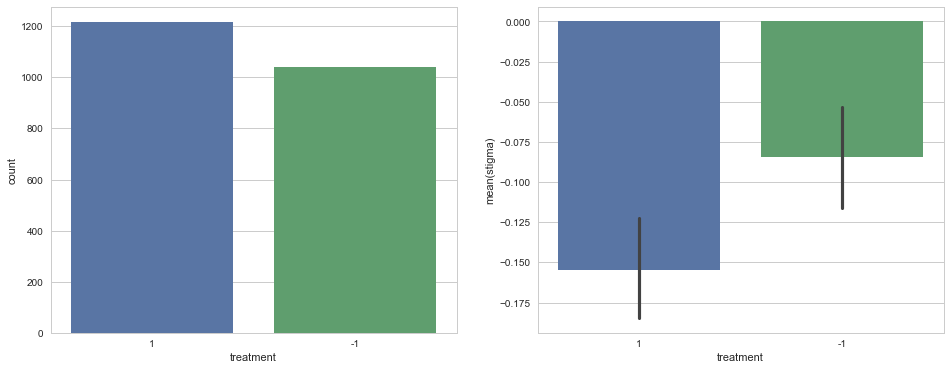

In [62]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(x='treatment', data=combined_df, ax=ax1, order=combined_df.treatment.value_counts().index)
sns.barplot(x='treatment', y='stigma', data=combined_df, ax=ax2, order=combined_df.treatment.value_counts().index)

### Interferes With Work

In [63]:
# Lump 'Not applicable to me' with NaN
combined_df.loc[combined_df.work_interfere == 'Not applicable to me', 'work_interfere'] = np.nan

In [64]:
# According to OSMI Survey: 
# 'This survey is for everyone working in tech, not just those who have a mental health issue.'
# Assumption: IF work_interfere == N/A THEN treatment == 0 AND has_illness = 0
combined_df.loc[(combined_df.work_interfere.isnull()), 'treatment'] = 0

In [65]:
# One-Hot Encode
work_int_dummies = pd.get_dummies(combined_df.work_interfere.str.lower(),
                                  prefix='wint', dummy_na=True, drop_first=True)
combined_df = combined_df.join(work_int_dummies)

### Number of Employees

In [66]:
# Convert num_employees into new features: sm_comp, med_comp, lg_comp
num_emp_map = {'1-5': 'sm', '6-25': 'sm', '26-100': 'sm',
               '100-500': 'med', '500-1000': 'med', 'More than 1000': 'lg'}
combined_df['company_size'] = combined_df.num_employees.map(num_emp_map)

In [67]:
# One-Hot Encode
comp_size_dummies = pd.get_dummies(combined_df.company_size, prefix='comp', drop_first=True)
combined_df = combined_df.join(comp_size_dummies)

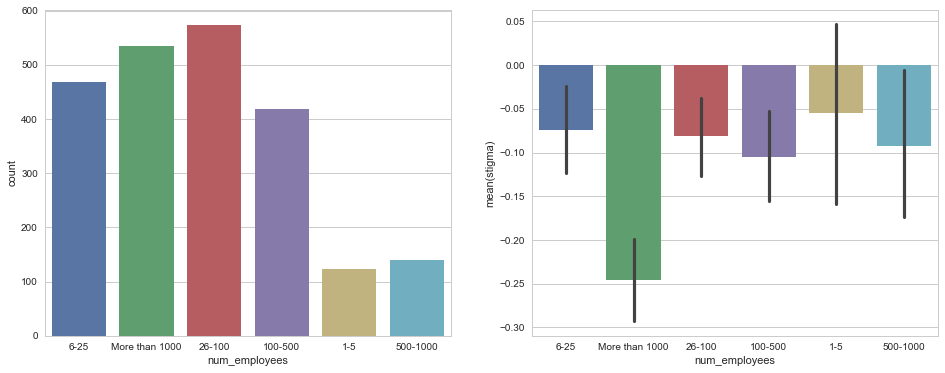

In [68]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(x='num_employees', data=combined_df, ax=ax1)
sns.barplot(x='num_employees', y='stigma', data=combined_df, ax=ax2)

### Work Remotely

In [69]:
combined_df.loc[(combined_df.remote == 'No') | (combined_df.remote == 'Never'), 'remote'] = -1
combined_df.loc[(combined_df.remote == 'Sometimes'), 'remote'] = 0
combined_df.loc[(combined_df.remote == 'Yes') | (combined_df.remote == 'Always'), 'remote'] = 1

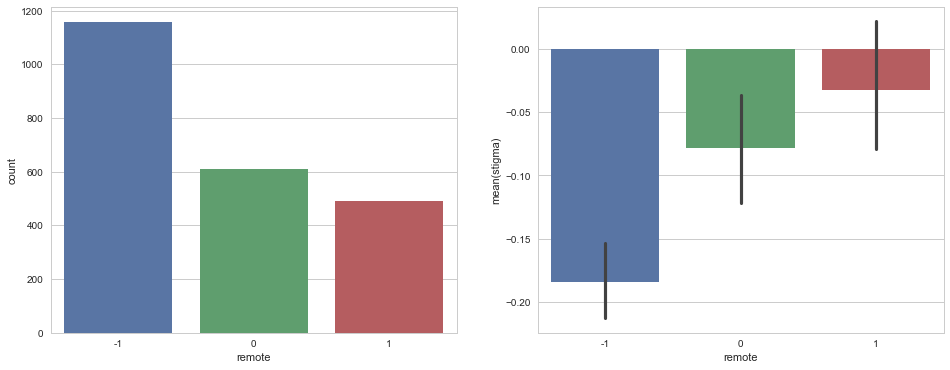

In [70]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(x='remote', data=combined_df, ax=ax1)
sns.barplot(x='remote', y='stigma', data=combined_df, ax=ax2)

### Tech Company

In [71]:
combined_df.loc[(combined_df.tech_comp == 'No') | (combined_df.tech_comp == 0), 'tech_comp'] = -1
combined_df.loc[(combined_df.tech_comp == 'Yes'), 'tech_comp'] = 1

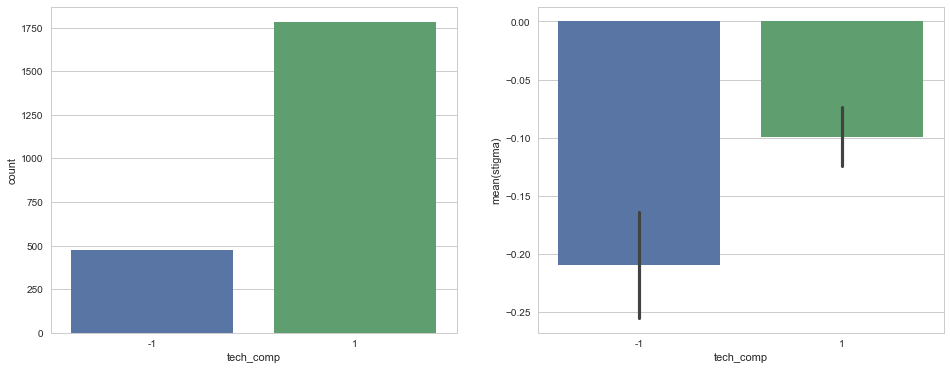

In [72]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(x='tech_comp', data=combined_df, ax=ax1)
sns.barplot(x='tech_comp', y='stigma', data=combined_df, ax=ax2)

### Benefits

In [73]:
combined_df.loc[(combined_df.benefits == 'No') | (
    combined_df.benefits == 'Not eligible for coverage / N/A'), 'benefits'] = -1
combined_df.loc[(combined_df.benefits == 'I don\'t know') | (
    combined_df.benefits == 'Don\'t know'), 'benefits'] = 0
combined_df.loc[(combined_df.benefits == 'Yes'), 'benefits'] = 1

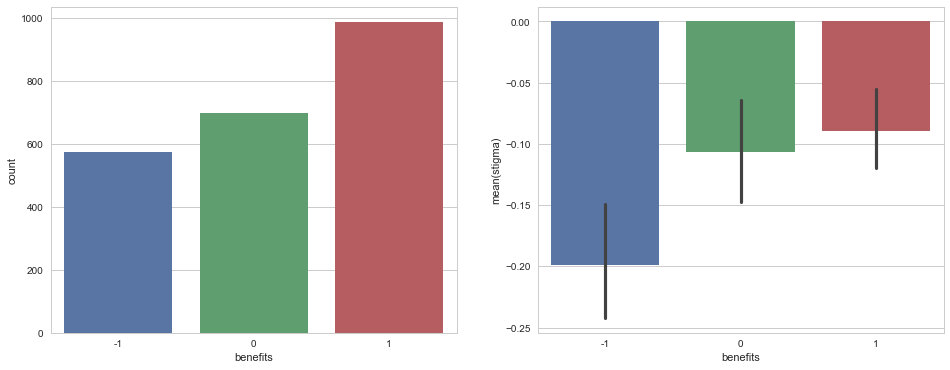

In [74]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(x='benefits', data=combined_df, ax=ax1)
sns.barplot(x='benefits', y='stigma', data=combined_df, ax=ax2)

### Anonymity

In [75]:
combined_df.loc[(combined_df.anon == 'No'), 'anon'] = -1
combined_df.loc[(combined_df.anon == 'I don\'t know') | (
    combined_df.anon == 'Don\'t know'), 'anon'] = 0
combined_df.loc[(combined_df.anon == 'Yes'), 'anon'] = 1

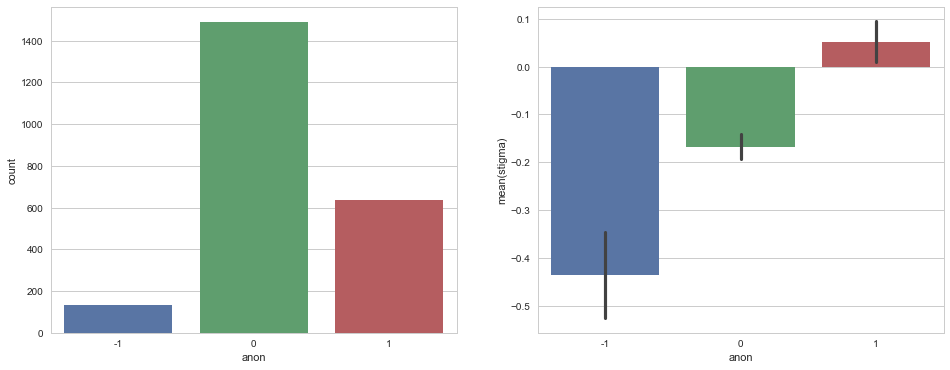

In [76]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(x='anon', data=combined_df, ax=ax1)
sns.barplot(x='anon', y='stigma', data=combined_df, ax=ax2)

### Medical Leave

In [77]:
# Relabel
combined_df.loc[(combined_df.med_leave == 'I don\'t know') | (
    combined_df.med_leave == 'Don\'t know'), 'med_leave'] = 'unknown'
combined_df.loc[(combined_df.med_leave == 'Very easy'), 'med_leave'] = 'hi_easy'
combined_df.loc[(combined_df.med_leave == 'Somewhat easy'), 'med_leave'] = 'lo_easy'
combined_df.loc[(combined_df.med_leave == 'Neither easy nor difficult'), 'med_leave'] = 'med'
combined_df.loc[(combined_df.med_leave == 'Somewhat difficult'), 'med_leave'] = 'lo_hard'
combined_df.loc[(combined_df.med_leave == 'Very difficult'), 'med_leave'] = 'hi_hard'

In [78]:
# One-Hot Encode
med_leave_dummies = pd.get_dummies(combined_df.med_leave, prefix='mleave', drop_first=True)
combined_df = combined_df.join(med_leave_dummies)

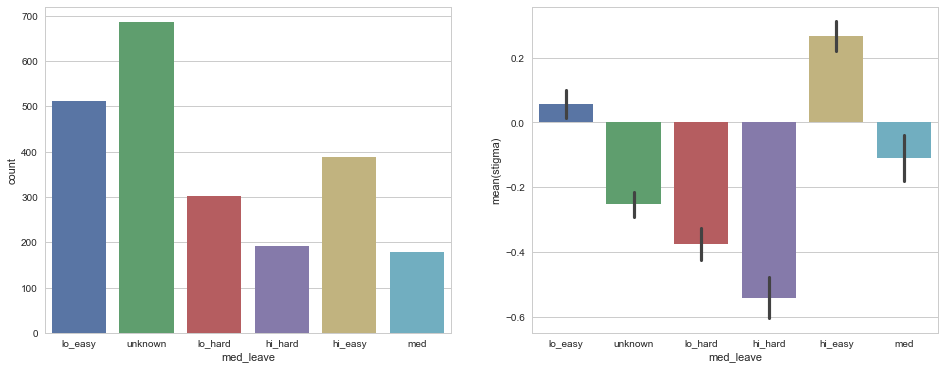

In [79]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(x='med_leave', data=combined_df, ax=ax1)
sns.barplot(x='med_leave', y='stigma', data=combined_df, ax=ax2)

### Observed Others Receiving Negative Consequences

In [80]:
combined_df.loc[(combined_df.obs_conseq == 'No') | (combined_df.obs_conseq == 0), 'obs_conseq'] = -1
combined_df.loc[(combined_df.obs_conseq == 'Yes'), 'obs_conseq'] = 1

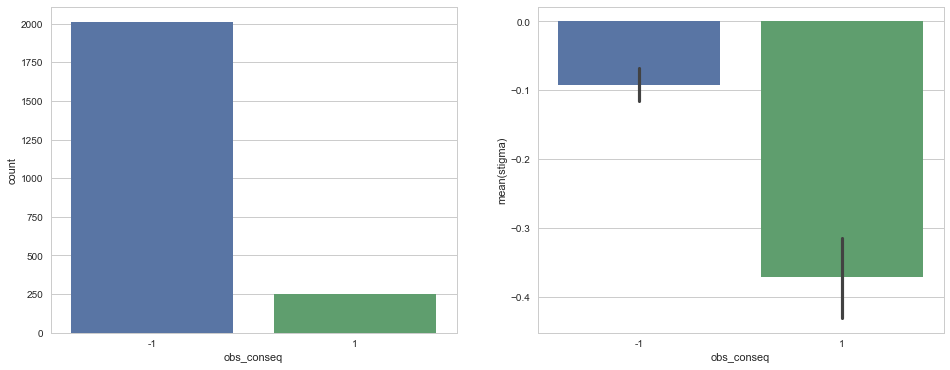

In [81]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(x='obs_conseq', data=combined_df, ax=ax1)
sns.barplot(x='obs_conseq', y='stigma', data=combined_df, ax=ax2)

### Continent

In [82]:
# get country to continent mapping and add as new feature
geo_cc = pd.Series(geo_divs.set_index('country').continent)
continent = combined_df.country_live.map(geo_cc)
combined_df['continent'] = continent

In [83]:
# One-Hot Encode
continent_dummies = pd.get_dummies(combined_df.continent.str.lower(), drop_first=True)
combined_df = combined_df.join(continent_dummies)

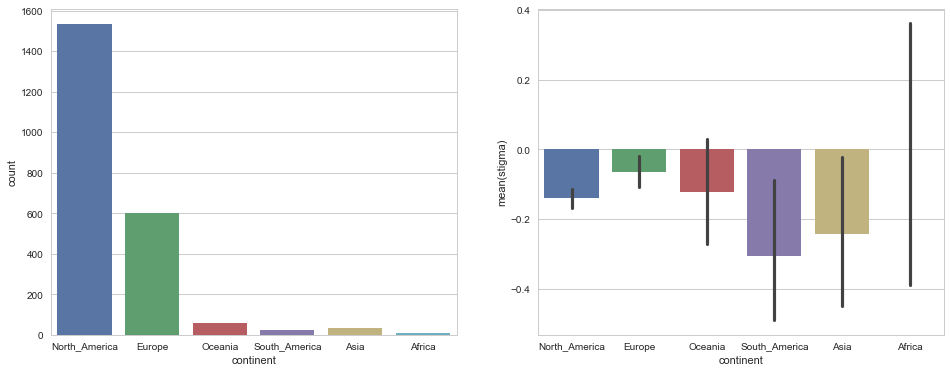

In [84]:
# plot counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(x='continent', data=combined_df, ax=ax1)
sns.barplot(x='continent', y='stigma', data=combined_df, ax=ax2)

In [85]:
combined_df.head()

,date_submit,num_employees,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,phys_interv,ment_interv,family_history,treatment,age,gender,country_live,state_live,remote,work_interfere,stigma,resource_promo,phys_ment,year,month,week_day,hour,location,wint_often,wint_rarely,wint_sometimes,wint_nan,company_size,comp_med,comp_sm,mleave_hi_hard,mleave_lo_easy,mleave_lo_hard,mleave_med,mleave_unknown,continent,asia,europe,north_america,oceania,south_america
0,2014-08-27 11:29:31,6-25,1,1,0,-1,1,1,lo_easy,-1,-1,0,1,1,-1,0,-1,-1,1,37,1,United States,Illinois,-1,Often,0.25,0,0.4,2014,8,2,11,Illinois,1,0,0,0,sm,0,1,0,1,0,0,0,North_America,0,0,1,0,0
1,2014-08-27 11:29:37,More than 1000,-1,0,-1,0,0,0,unknown,0,-1,-1,-1,0,-1,-1,-1,-1,-1,44,-1,United States,Indiana,-1,Rarely,-0.75,-0.333333,0.2,2014,8,2,11,Indiana,0,1,0,0,lg,0,0,0,0,0,0,1,North_America,0,0,1,0,0
2,2014-08-27 11:29:44,6-25,1,-1,-1,-1,-1,0,lo_hard,-1,-1,1,1,-1,-1,1,1,-1,-1,32,-1,Canada,NaN,-1,Rarely,1,-1,-0.2,2014,8,2,11,Canada,0,1,0,0,sm,0,1,0,0,1,0,0,North_America,0,0,1,0,0
3,2014-08-27 11:29:46,26-100,1,-1,1,-1,-1,-1,lo_hard,1,1,0,-1,-1,1,0,0,1,1,31,-1,United Kingdom,NaN,-1,Often,-0.5,-0.333333,-0.2,2014,8,2,11,United Kingdom,1,0,0,0,sm,0,1,0,0,1,0,0,Europe,0,1,0,0,0
4,2014-08-27 11:30:22,100-500,1,1,-1,0,0,0,unknown,-1,-1,0,1,0,-1,1,1,-1,-1,31,-1,United States,Texas,1,Never,0.75,-0.333333,0,2014,8,2,11,Texas,0,0,0,0,med,1,0,0,0,0,0,1,North_America,0,0,1,0,0


### Drop Non-Numeric Columns

In [86]:
combined_df2 = combined_df.drop(['date_submit', 'country_live', 'state_live', 'work_interfere', 'num_employees',
                                'med_leave', 'location', 'company_size', 'continent'], axis=1)

In [87]:
combined_df2.head()

,tech_comp,benefits,care_options,wellness_program,emp_help,anon,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,phys_interv,ment_interv,family_history,treatment,age,gender,remote,stigma,resource_promo,phys_ment,year,month,week_day,hour,wint_often,wint_rarely,wint_sometimes,wint_nan,comp_med,comp_sm,mleave_hi_hard,mleave_lo_easy,mleave_lo_hard,mleave_med,mleave_unknown,asia,europe,north_america,oceania,south_america
0,1,1,0,-1,1,1,-1,-1,0,1,1,-1,0,-1,-1,1,37,1,-1,0.25,0,0.4,2014,8,2,11,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
1,-1,0,-1,0,0,0,0,-1,-1,-1,0,-1,-1,-1,-1,-1,44,-1,-1,-0.75,-0.333333,0.2,2014,8,2,11,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,1,-1,-1,-1,-1,0,-1,-1,1,1,-1,-1,1,1,-1,-1,32,-1,-1,1,-1,-0.2,2014,8,2,11,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
3,1,-1,1,-1,-1,-1,1,1,0,-1,-1,1,0,0,1,1,31,-1,-1,-0.5,-0.333333,-0.2,2014,8,2,11,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
4,1,1,-1,0,0,0,-1,-1,0,1,0,-1,1,1,-1,-1,31,-1,1,0.75,-0.333333,0,2014,8,2,11,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [88]:
combined_df2.isnull().values.any()

False

# Clean States Human Development Index (HDI)   

In [89]:
df_statesHDI= pd.read_csv('data/state_hdi.csv')

In [90]:
df_statesHDI

,Gender,Race/Ethnicity,Year,State,HD Index,Life Expectancy at Birth (years),Less Than High School (%),At Least High School Diploma (%),At Least Bachelor's Degree (%),Graduate Degree (%),School Enrollment (%),Median Earnings (2010 dollars),Health Index,Education Index,Income Index,Diabetes (% age 18 and older),Low-Birth-Weight Infants (% of all infants),"Trauma-Related Death Rate (per 100,000 population)",3- and 4-year-olds Not Enrolled in Preschool (%),4th Graders Reading Below Proficiency (%),High School Freshmen Not Graduating After 4 Years (%),Children Under 6 Living in Poverty (%),Adults 65 and Older Living in Poverty (%),"Marginally Attached Workers (per 10,000 working-age Adults)",Renters with Severe Housing-Cost Burden (gross rent > 50% of household income),Preschool Enrollment (% enrolled ages 3 and 4),Students Learning English as a Second Language (% public K-12),Special Education Students (% public K-12),Economically Disadvantaged Students (% public K-12),4th Grade National Assessment of Educational Progress in Reading (% at or above proficient),8th Grade National Assessment of Educational Progress in Math (% at or above proficient),Public High School Graduation Rate (%),High School Graduates Enrolling in College (%),Annual Costs of Public 4-Year College (average $),Annual Costs of Private 4-Year College (average $),Annual Costs of Public 2-Year College (average $),"Per Pupil Spending, Public K-12 ($)",State Spending on Higher Education ($ per capita),State Spending on Academic Research and Development ($ per capita),Individuals with Home Internet Access (% ages 3 and older),Teenagers Not in School and Not Working (% ages 16-19),Total Population,Population under 18 (%),Population over 65 (%),Urban Population (%),Rural Population (%),White not Latino Population (%),Latino Population (%),African American Population (%),Asian American Population (%),Native American Population (%),Population some other race or races (%),Renters Spending 30% or More on Housing (%),Owners Spending 30% or More on Housing (%),Housing Units Occupied by Owner (%),Housing Units with 1.01 or More Occupants per Room (%),"Foreclosures (per 10,000 homes)",Homeless Population (total number),Homeless (% of population),"Commute 60 Minutes or More (% of workers, 16 and over)",Commute by Carpool (% of workers),State Expenditure on Transportation ($ per person),"Infant Mortality Rate (per 1,000 live births)",Low-Birth-Weight Infants (% of all infants).1,"Child Mortality (age 1-4, per 100,000 population)",Food-Insecure Households (%),Child Immunization Rate (%),Diabetes (% age 18 and older).1,Obesity (% age 20 and older),"Births to Teenage Girls (per 1,000 age 15-19)","Practicing Physicians (per 10,000 population)",Smoking (% age 18 and older),Binge Drinking (% adults in past 30 days),Uninsured (% of individuals lacking coverage),Medicare Recipients (thousands),Medicaid Recipients (thousands),Medicaid Eligibility Cutoff (income as % of poverty line),State Medicaid Spending (per recipient),Children on Medicaid (% age 0 -18),Army Recruits (total),"Army Recruits (per 1,000 youth)","Army Recruits (per 1,000 youth).1",Change in Army Recruits from 2007 to 2008 (%),"Total Military Casualties in Operations Enduring Freedom and Iraqi Freedom, to April 2010","Violent Crime (per 100,000)","Property Crime (per 100,000)","Homicide (per 100,000)",Homicide by Firearm (%),"Suicide (per 100,000 age-adjusted)",Rape (total number),"Rape (per 100,000)","Child Maltreatment (per 1,000 children)",State Police Expenditure ($ per resident),"Prisoners, State or Federal Jurisdiction (total number)","Incarceration Rate (per 100,000 inhabitants)",State Expenditure on Corrections ($ per prisoner),Turnout (% of eligible voters who voted),Change in Turnout from 2004,"Ineligible to Vote Due to Felony Convictions (per 100,000 voting-age population)",Seats in State Legislatures Held by Women (%),Women in Congressional Delegation (total),Men in Congressional Delegation (total),Carbon Dioxid

In [91]:
df_statesHDI_relabel = ['gender', 'race', 'year', 'state', 'HDI', 'life_exp', 'less_HS', 'HS', 'BS', 'Graduate', 
                        'sch_enroll', 'earn', 'HI', 'eduI', 'inci', 'diabe', 'low_birth','trauma', 'preschool', 
                        'reading', 'HS_Grad', 'child_poverty', 'adults_poverty', 'workers', 'housings', 'pre_enroll',
                        'ESL2','ESL', 'EDS', 'edu_process', '8th_progress', 'public_grad', 'HS_coll', 'cost_public', 
                        'priv_cost', '2year_cost', 'pupil_spending', 'state_spending', 'research_spending', 'interent'
                        , 'teens','total_pop', 'pop_18', 'pop_65', 'urban', 'rural', 'white', 'latino', 'african_am',
                        'asian', 'nativeam', 'pop_other', 'renters_spend', 'oweners_spend', 'house_units', 'house_2', 
                        'foreclosures', 'homless', 'homeless_pop', 'commute', 'carpool', 'state-expen', 'infant',
                        'low_birthhr', 'child_mortality', 'food', 'child_immun', 'diabetes_18', 'obesity', 
                        'teen_birch', 'pysicians', 'smoking', 'drinking', 'uninsured', 'medicare', 'medicad',
                        'medicad2', 'state_medicaid', 'child_medi', 'amry1', 'amry2', 'army3', 'army4', 'military', 
                        'crime', 'property', 'homicide', 'homicide_firearm', 'suicide', 'rape', 'rape2', 
                        'child_maltreatment', 'state_police', 'prisoners', 'incarceration', 'state_expen', 'voters',
                        'change', 'vote_felony', 'state_legis', 'women_congree', 'men_congree', 'co2', 'carcinogen',
                        'lead', 'mercury', 'dioxin', 'superfund', 'forest', 'farm','energy', 'water', 'labor', 'GDP', 
                        'wage', 'gini', 'pover', 'child_pov',  'fed_revenure', 'state_assistance', 'food_stamps',
                        'unemploy_rate', 'union', 'income_earn', 'bamkrup', 'mngt', 'service', 'sales', 'farming', 
                        'construction', 'production']

In [92]:
df_statesHDI.columns = df_statesHDI_relabel

In [93]:
df_statesHDI.shape

(3674, 131)

In [94]:
df_statesHDI.drop(['life_exp', 'less_HS', 'HS', 'BS', 'Graduate', 
                        'sch_enroll', 'earn', 'HI', 'eduI', 'inci', 'diabe', 'low_birth','trauma', 'preschool', 
                        'reading', 'HS_Grad', 'child_poverty', 'adults_poverty', 'workers', 'housings', 'pre_enroll',
                        'ESL2','ESL', 'EDS', 'edu_process', '8th_progress', 'public_grad', 'HS_coll', 'cost_public', 
                        'priv_cost', '2year_cost', 'pupil_spending', 'state_spending', 'research_spending', 'interent'
                        , 'teens','total_pop', 'pop_18', 'pop_65', 'urban', 'rural', 'white', 'latino', 'african_am',
                        'asian', 'nativeam', 'pop_other', 'renters_spend', 'oweners_spend', 'house_units', 'house_2', 
                        'foreclosures', 'homless', 'homeless_pop', 'commute', 'carpool', 'state-expen', 'infant',
                        'low_birthhr', 'child_mortality', 'food', 'child_immun', 'diabetes_18', 'obesity', 
                        'teen_birch', 'pysicians', 'smoking', 'drinking', 'uninsured', 'medicare', 'medicad',
                        'medicad2', 'state_medicaid', 'child_medi', 'amry1', 'amry2', 'army3', 'army4', 'military', 
                        'crime', 'property', 'homicide', 'homicide_firearm', 'suicide', 'rape', 'rape2', 
                        'child_maltreatment', 'state_police', 'prisoners', 'incarceration', 'state_expen', 'voters',
                        'change', 'vote_felony', 'state_legis', 'women_congree', 'men_congree', 'co2', 'carcinogen',
                        'lead', 'mercury', 'dioxin', 'superfund', 'forest', 'farm','energy', 'water', 'labor', 'GDP', 
                        'wage', 'gini', 'pover', 'child_pov',  'fed_revenure', 'state_assistance', 'food_stamps',
                        'unemploy_rate', 'union', 'income_earn', 'bamkrup', 'mngt', 'service', 'sales', 'farming', 
                        'construction', 'production'], axis=1, inplace = True)

In [95]:
df_statesHDI.shape

(3674, 5)

In [96]:
df_statesHDI

,gender,race,year,state,HDI
0,ALL,ALL,2010.0,UNITED STATES,5.03
1,ALL,ALL,2010.0,Alabama,4.04
2,ALL,ALL,2010.0,Alaska,5.06
3,ALL,ALL,2010.0,Arizona,4.89
4,ALL,ALL,2010.0,Arkansas,3.91
5,ALL,ALL,2010.0,California,5.4
6,ALL,ALL,2010.0,Colorado,5.53
7,ALL,ALL,2010.0,Connecticut,6.17
8,ALL,ALL,2010.0,Delaware,5.22
9,ALL,ALL,2010.0,District of Columbia,6.08


In [97]:
#only keep year 2010 and drop the rest, keep data with all race/ethnicities and genders, drop the rest 

df_statesHDI= df_statesHDI[df_statesHDI.year == 2010]
df_statesHDI= df_statesHDI[df_statesHDI.race == 'ALL']
df_statesHDI= df_statesHDI[df_statesHDI.gender == 'ALL']
df_statesHDI.dropna(axis = 0, how = 'any', inplace=True)

In [98]:
df_statesHDI.drop(['gender', 'race', 'year'], axis=1, inplace = True)


In [99]:
df_statesHDI

,state,HDI
0,UNITED STATES,5.03
1,Alabama,4.04
2,Alaska,5.06
3,Arizona,4.89
4,Arkansas,3.91
5,California,5.4
6,Colorado,5.53
7,Connecticut,6.17
8,Delaware,5.22
9,District of Columbia,6.08


In [100]:
df_statesHDI = df_statesHDI.drop(df_statesHDI.index[0])

In [101]:
dict_states = dict(zip(df_statesHDI.state,df_statesHDI.HDI))
dict_states

{'Alabama': '4.04',
 'Alaska': '5.06',
 'Arizona': '4.89',
 'Arkansas': '3.91',
 'California': '5.4',
 'Colorado': '5.53',
 'Connecticut': '6.17',
 'Delaware': '5.22',
 'District of Columbia': '6.08',
 'Florida': '4.82',
 'Georgia': '4.62',
 'Hawaii': '5.53',
 'Idaho': '4.5',
 'Illinois': '5.31',
 'Indiana': '4.56',
 'Iowa': '5.03',
 'Kansas': '4.96',
 'Kentucky': '4.02',
 'Louisiana': '4.12',
 'Maine': '4.93',
 'Maryland': '5.94',
 'Massachusetts': '6.16',
 'Michigan': '4.76',
 'Minnesota': '5.69',
 'Mississippi': '3.81',
 'Missouri': '4.6',
 'Montana': '4.54',
 'Nebraska': '5.11',
 'Nevada': '4.63',
 'New Hampshire': '5.73',
 'New Jersey': '6.12',
 'New Mexico': '4.52',
 'New York': '5.66',
 'North Carolina': '4.57',
 'North Dakota': '4.9',
 'Ohio': '4.71',
 'Oklahoma': '4.14',
 'Oregon': '4.86',
 'Pennsylvania': '5.07',
 'Rhode Island': '5.38',
 'South Carolina': '4.35',
 'South Dakota': '4.79',
 'Tennessee': '4.22',
 'Texas': '4.65',
 'Utah': '5.03',
 'Vermont': '5.31',
 'Virginia'

In [102]:
combined_df['HDI'] = combined_df['location'].replace( dict_states  )

# Country HDI Cleaning 

In [103]:
df_countryHDI= pd.read_csv('data/country_hdi.csv')

In [104]:
df_countryHDI

,Country,2010,2011,2012,2013,2014,2015
0,Afghanistan,0.454,0.463,0.470,0.476,0.479,0.479
1,Albania,0.738,0.752,0.759,0.761,0.762,0.764
2,Algeria,0.724,0.732,0.737,0.741,0.743,0.745
3,Andorra,0.819,0.819,0.843,0.850,0.857,0.858
4,Angola,0.495,0.508,0.523,0.527,0.531,0.533
5,Antigua and Barbuda,0.782,0.778,0.781,0.782,0.784,0.786
6,Argentina,0.816,0.822,0.823,0.825,0.826,0.827
7,Armenia,0.729,0.732,0.736,0.739,0.741,0.743
8,Australia,0.927,0.930,0.933,0.936,0.937,0.939
9,Austria,0.880,0.884,0.887,0.892,0.892,0.893


In [105]:
df_countryHDI.drop(['2010', '2011', '2012', '2013', '2014'], axis=1, inplace = True)

In [106]:

country_relabel =['country', 'HDI']
df_countryHDI.columns = country_relabel

df_countryHDI['country'] = df_countryHDI['country'].str.strip()

In [107]:

dict_country = dict(zip(df_countryHDI.country,df_countryHDI.HDI))
dict_country

{'Afghanistan': 0.47899999999999998,
 'Albania': 0.76400000000000001,
 'Algeria': 0.745,
 'Andorra': 0.85799999999999998,
 'Angola': 0.53299999999999992,
 'Antigua and Barbuda': 0.78599999999999992,
 'Argentina': 0.82700000000000007,
 'Armenia': 0.74299999999999999,
 'Australia': 0.93900000000000006,
 'Austria': 0.89300000000000002,
 'Azerbaijan': 0.75900000000000001,
 'Bahamas': 0.79200000000000004,
 'Bahrain': 0.82400000000000007,
 'Bangladesh': 0.57899999999999996,
 'Barbados': 0.79500000000000004,
 'Belarus': 0.79599999999999993,
 'Belgium': 0.89599999999999991,
 'Belize': 0.70599999999999996,
 'Benin': 0.48499999999999999,
 'Bhutan': 0.60699999999999998,
 'Bolivia (Plurinational State of)': 0.67400000000000004,
 'Bosnia and Herzegovina': 0.75,
 'Botswana': 0.69799999999999995,
 'Brazil': 0.754,
 'Brunei Darussalam': 0.86499999999999999,
 'Bulgaria': 0.79400000000000004,
 'Burkina Faso': 0.40200000000000002,
 'Burundi': 0.40399999999999997,
 'Cabo Verde': 0.64800000000000002,
 'Cam

In [108]:
#dict_country
combined_df['HDI']  = combined_df['HDI'].replace(dict_country)

In [109]:
combined_df

,date_submit,num_employees,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,phys_interv,ment_interv,family_history,treatment,age,gender,country_live,state_live,remote,work_interfere,stigma,resource_promo,phys_ment,year,month,week_day,hour,location,wint_often,wint_rarely,wint_sometimes,wint_nan,company_size,comp_med,comp_sm,mleave_hi_hard,mleave_lo_easy,mleave_lo_hard,mleave_med,mleave_unknown,continent,asia,europe,north_america,oceania,south_america,HDI
0,2014-08-27 11:29:31,6-25,1,1,0,-1,1,1,lo_easy,-1,-1,0,1,1,-1,0,-1,-1,1,37,1,United States,Illinois,-1,Often,0.25,0,0.4,2014,8,2,11,Illinois,1,0,0,0,sm,0,1,0,1,0,0,0,North_America,0,0,1,0,0,5.31
1,2014-08-27 11:29:37,More than 1000,-1,0,-1,0,0,0,unknown,0,-1,-1,-1,0,-1,-1,-1,-1,-1,44,-1,United States,Indiana,-1,Rarely,-0.75,-0.333333,0.2,2014,8,2,11,Indiana,0,1,0,0,lg,0,0,0,0,0,0,1,North_America,0,0,1,0,0,4.56
2,2014-08-27 11:29:44,6-25,1,-1,-1,-1,-1,0,lo_hard,-1,-1,1,1,-1,-1,1,1,-1,-1,32,-1,Canada,NaN,-1,Rarely,1,-1,-0.2,2014,8,2,11,Canada,0,1,0,0,sm,0,1,0,0,1,0,0,North_America,0,0,1,0,0,0.92
3,2014-08-27 11:29:46,26-100,1,-1,1,-1,-1,-1,lo_hard,1,1,0,-1,-1,1,0,0,1,1,31,-1,United Kingdom,NaN,-1,Often,-0.5,-0.333333,-0.2,2014,8,2,11,United Kingdom,1,0,0,0,sm,0,1,0,0,1,0,0,Europe,0,1,0,0,0,0.91
4,2014-08-27 11:30:22,100-500,1,1,-1,0,0,0,unknown,-1,-1,0,1,0,-1,1,1,-1,-1,31,-1,United States,Texas,1,Never,0.75,-0.333333,0,2014,8,2,11,Texas,0,0,0,0,med,1,0,0,0,0,0,1,North_America,0,0,1,0,0,4.65
5,2014-08-27 11:31:22,6-25,1,1,0,-1,0,0,unknown,-1,-1,1,1,0,-1,0,-1,1,-1,33,-1,United States,Tennessee,-1,Sometimes,0.5,-0.333333,0.2,2014,8,2,11,Tennessee,0,0,1,0,sm,0,1,0,0,0,0,1,North_America,0,0,1,0,0,4.22
6,2014-08-27 11:31:50,1-5,1,-1,-1,-1,-1,-1,lo_hard,0,0,0,-1,0,-1,-1,-1,1,1,35,1,United States,Michigan,1,Sometimes,-0.5,-1,0,2014,8,2,11,Michigan,0,0,1,0,sm,0,1,0,0,1,0,0,North_America,0,0,1,0,0,4.76
7,2014-08-27 11:32:05,1-5,1,-1,1,-1,-1,1,unknown,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,39,-1,Canada,NaN,1,Never,-0.5,-0.333333,-0.2,2014,8,2,11,Canada,0,0,0,0,sm,0,1,0,0,0,0,1,North_America,0,0,1,0,0,0.92
8,2014-08-27 11:32:39,100-500,1,1,1,-1,-1,-1,hi_hard,0,-1,1,1,-1,-1,0,-1,1,1,42,1,United States,Illinois,-1,Sometimes,0.25,-0.333333,0.2,2014,8,2,11,Illinois,0,0,1,0,med,1,0,1,0,0,0,0,North_America,0,0,1,0,0,5.31
9,2014-08-27 11:32:43,26-100,1,0,-1,0,0,0,unknown,-1,-1,1,1,1,-1,0,0,-1,-1,23,-1,Canada,NaN,-1,Never,0.75,-0.333333,0.2,2014,8,2,11,Canada,0,0,0,0,sm,0,1,0,0,0,0,1,North_America,0,0,1,0,0,0.92


In [121]:
value = combined_df.loc[combined_df['location']=='Illinois', 'stigma']
value.mean()

-0.16095890410958905

In [123]:
location_unique = combined_df.location.unique()

In [137]:
for row in location_unique:
    loc_mean_stigma = combined_df.loc[combined_df['location'] == row, 'stigma'].mean()
    print(loc_mean_stigma)

-0.16095890411
0.0478723404255
-0.147177419355
-0.0524054982818
-0.23417721519
-0.0688405797101
0.00793650793651
-0.367346938776
-0.1
-0.207489878543
-0.107142857143
-0.120689655172
-0.0131578947368
-0.0833333333333
-0.25
-0.180555555556
-0.625
0.0588235294118
-0.078125
-0.0416666666667
-0.142857142857
-0.0909090909091
-0.111111111111
-0.25
-0.0194805194805
-0.00446428571429
-0.137931034483
-0.25
0.0974576271186
-0.261363636364
0.125
-0.2
-0.134615384615
-0.163793103448
-0.184782608696
-0.0416666666667
-0.75
0.0416666666667
0.75
-0.0394736842105
0.0833333333333
-0.116071428571
-0.5
-0.370967741935
-0.220588235294
-0.214285714286
-0.234848484848
-0.147058823529
-0.125
-0.28125
0.047619047619
-0.03125
-0.464285714286
0.05
-0.2
-0.159090909091
-0.3125
-0.208333333333
-0.333333333333
-0.25
0.125
-0.166666666667
-0.388888888889
-0.160714285714
-0.3125
0.0
-0.6875
-0.25
-0.285714285714
-0.0454545454545
-0.583333333333
0.125
-0.625
0.0
0.25
0.0
-0.5
0.0416666666667
-0.875
0.5
1.0
0.375
-0.75


In [138]:
combined_df['stigma_mean_loc'] = combined_df['location'].replace(loc_mean_stigma)

,date_submit,num_employees,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,phys_interv,ment_interv,family_history,treatment,age,gender,country_live,state_live,remote,work_interfere,stigma,resource_promo,phys_ment,year,month,week_day,hour,location,wint_often,wint_rarely,wint_sometimes,wint_nan,company_size,comp_med,comp_sm,mleave_hi_hard,mleave_lo_easy,mleave_lo_hard,mleave_med,mleave_unknown,continent,asia,europe,north_america,oceania,south_america,HDI,stigma_mean_loc
0,2014-08-27 11:29:31,6-25,1,1,0,-1,1,1,lo_easy,-1,-1,0,1,1,-1,0,-1,-1,1,37,1,United States,Illinois,-1,Often,0.25,0,0.4,2014,8,2,11,Illinois,1,0,0,0,sm,0,1,0,1,0,0,0,North_America,0,0,1,0,0,5.31,Illinois
1,2014-08-27 11:29:37,More than 1000,-1,0,-1,0,0,0,unknown,0,-1,-1,-1,0,-1,-1,-1,-1,-1,44,-1,United States,Indiana,-1,Rarely,-0.75,-0.333333,0.2,2014,8,2,11,Indiana,0,1,0,0,lg,0,0,0,0,0,0,1,North_America,0,0,1,0,0,4.56,Indiana
2,2014-08-27 11:29:44,6-25,1,-1,-1,-1,-1,0,lo_hard,-1,-1,1,1,-1,-1,1,1,-1,-1,32,-1,Canada,NaN,-1,Rarely,1,-1,-0.2,2014,8,2,11,Canada,0,1,0,0,sm,0,1,0,0,1,0,0,North_America,0,0,1,0,0,0.92,Canada
3,2014-08-27 11:29:46,26-100,1,-1,1,-1,-1,-1,lo_hard,1,1,0,-1,-1,1,0,0,1,1,31,-1,United Kingdom,NaN,-1,Often,-0.5,-0.333333,-0.2,2014,8,2,11,United Kingdom,1,0,0,0,sm,0,1,0,0,1,0,0,Europe,0,1,0,0,0,0.91,United Kingdom
4,2014-08-27 11:30:22,100-500,1,1,-1,0,0,0,unknown,-1,-1,0,1,0,-1,1,1,-1,-1,31,-1,United States,Texas,1,Never,0.75,-0.333333,0,2014,8,2,11,Texas,0,0,0,0,med,1,0,0,0,0,0,1,North_America,0,0,1,0,0,4.65,Texas
5,2014-08-27 11:31:22,6-25,1,1,0,-1,0,0,unknown,-1,-1,1,1,0,-1,0,-1,1,-1,33,-1,United States,Tennessee,-1,Sometimes,0.5,-0.333333,0.2,2014,8,2,11,Tennessee,0,0,1,0,sm,0,1,0,0,0,0,1,North_America,0,0,1,0,0,4.22,Tennessee
6,2014-08-27 11:31:50,1-5,1,-1,-1,-1,-1,-1,lo_hard,0,0,0,-1,0,-1,-1,-1,1,1,35,1,United States,Michigan,1,Sometimes,-0.5,-1,0,2014,8,2,11,Michigan,0,0,1,0,sm,0,1,0,0,1,0,0,North_America,0,0,1,0,0,4.76,Michigan
7,2014-08-27 11:32:05,1-5,1,-1,1,-1,-1,1,unknown,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,39,-1,Canada,NaN,1,Never,-0.5,-0.333333,-0.2,2014,8,2,11,Canada,0,0,0,0,sm,0,1,0,0,0,0,1,North_America,0,0,1,0,0,0.92,Canada
8,2014-08-27 11:32:39,100-500,1,1,1,-1,-1,-1,hi_hard,0,-1,1,1,-1,-1,0,-1,1,1,42,1,United States,Illinois,-1,Sometimes,0.25,-0.333333,0.2,2014,8,2,11,Illinois,0,0,1,0,med,1,0,1,0,0,0,0,North_America,0,0,1,0,0,5.31,Illinois
9,2014-08-27 11:32:43,26-100,1,0,-1,0,0,0,unknown,-1,-1,1,1,1,-1,0,0,-1,-1,23,-1,Canada,NaN,-1,Never,0.75,-0.333333,0.2,2014,8,2,11,Canada,0,0,0,0,sm,0,1,0,0,0,0,1,North_America,0,0,1,0,0,0.92,Canada
